In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install h5py
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tables
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install Glymur
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install opencv-python

Requirement already up-to-date: pip in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (20.1.1)


In [2]:
import h5py
import pandas as pd
import numpy as np
filename = "P4_catalog_v1.0_raw_classifications.hdf"
# df = pd.read_hdf(filename)

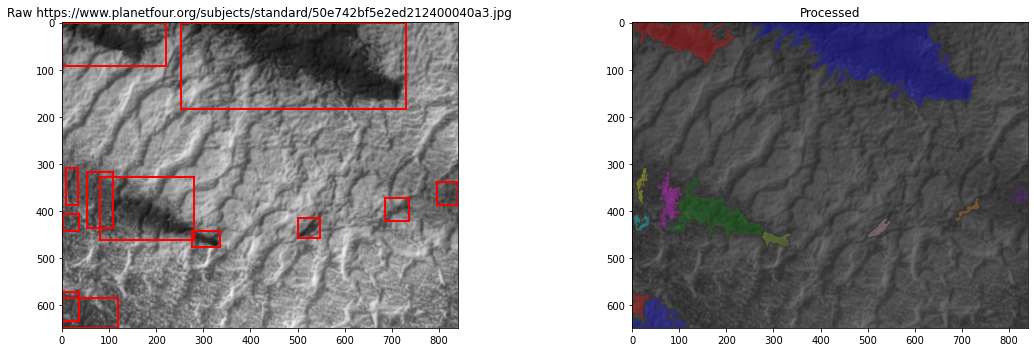

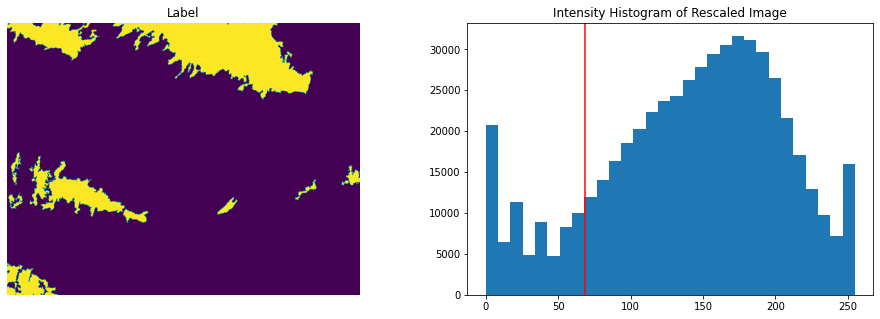

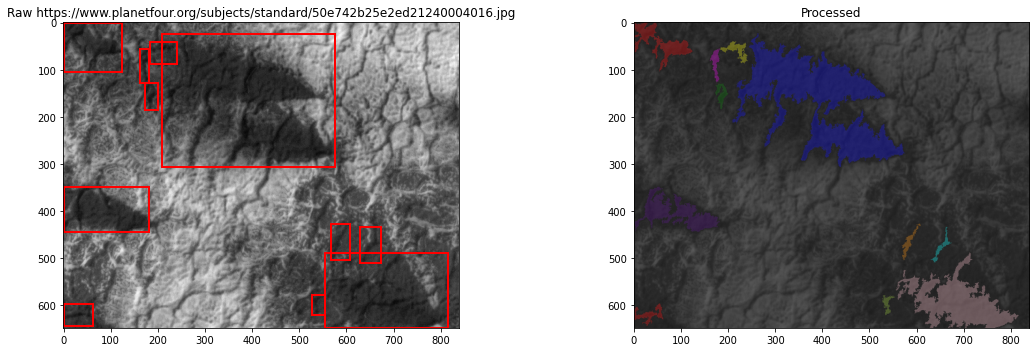

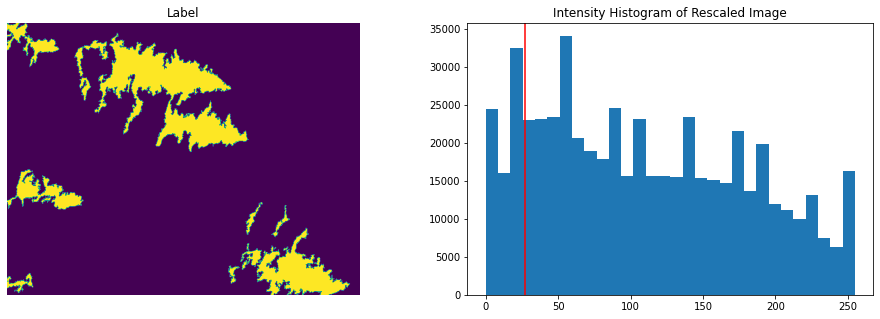

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_yen, threshold_triangle, threshold_otsu, threshold_li, sobel
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage import exposure
from skimage.io import imread

def plotter(image_url: str, advanced = False):   
    raw = imread(image_url)[..., 0]
    image = raw
    
    p2, p98 = np.percentile(image, (2, 98))
    rescaled = exposure.rescale_intensity(image, in_range=(p2, p98))
    sigma = 1.15
    thresh = np.mean(rescaled) -  sigma * np.std(rescaled) 
    
    bw = closing(rescaled < thresh, square(1))

    # Added post processing
    temp = ndi.binary_fill_holes(bw)
    label_objects, nb_labels = ndi.label(temp)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > 400
    mask_sizes[0] = 0
    clean_temp = mask_sizes[label_objects]
    
    # label image regions
    label_image = label(clean_temp)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(ncols=2, figsize=(8*2, 2.5*2))
    ax[0] = plt.subplot(1, 2, 1)
    ax[1] = plt.subplot(1, 2, 2)
    ax[0].imshow(raw, cmap=plt.cm.gray)
    ax[1].imshow(image_label_overlay)
#     ax[1].imshow(clean_temp)
    

    for region in regionprops(label_image):
        # take regions with large enough areas
        if 210000 >= region.area >= 100:
            # draw rectangle around segmented coins
            
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax[0].add_patch(rect)

    # ax[0].set_axis_off()
    ax[0].set_title(f"Raw {image_url}")
    ax[1].set_title(f"Processed")
    plt.tight_layout()
    
    if advanced:
        fig, axes = plt.subplots(ncols=2, figsize=(8*2, 2.5*2))
        ax = axes.ravel()
        ax[1] = plt.subplot(1, 2, 1)
        ax[0] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])

        ax[0].hist(rescaled.ravel(), bins=30)
        ax[0].set_title('Intensity Histogram of Rescaled Image')
        ax[0].axvline(thresh, color='r')

        ax[1].imshow(clean_temp)
        ax[1].set_title('Label')
        ax[1].axis('off')

"""
Limitations:
- Cannot pickup very small fans
- Will assume any large black thing is a fan. This includes a dip in terrain
"""

plot1 = "https://www.planetfour.org/subjects/standard/50e742bf5e2ed212400040a3.jpg"
plot2 = "https://www.planetfour.org/subjects/standard/50e742b25e2ed21240004016.jpg"

plotter(plot1, advanced = True)
plotter(plot2, advanced = True)
plt.show()

In [4]:
from glob import glob
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

drive_location = "/Users/Utkarsh/OneDrive - University of Toronto/SURF 2020/Code"
data_location = drive_location + '/data'
P4data_location = drive_location + "/P4 data"
glob(P4data_location + "/*.csv")

metadata = pd.read_csv(P4data_location + '/P4_catalog_v1.1_metadata.csv')
tiles_coord = pd.read_csv(P4data_location + '/P4_catalog_v1.1_tile_coords_final.csv')
fan = pd.read_csv(P4data_location + "/P4_catalog_v1.1_L1C_cut_0.5_fan.csv")
blotch = pd.read_csv(P4data_location + "/P4_catalog_v1.1_L1C_cut_0.5_blotch.csv")

print(len(metadata))
print(len(fan))
print(len(blotch))

item = tiles_coord.iloc[0].obsid
print(tiles_coord.iloc[0])
print(item)

pd.set_option('display.expand_frame_repr', False)
print(tiles_coord)
print(fan)
pd.set_option('display.expand_frame_repr', True)

221
158476
249801
x_tile                                    1
y_tile                                    1
x_hirise                                420
y_hirise                                324
PlanetocentricLatitude             -85.5041
PlanetographicLatitude             -85.5567
PositiveEast360Longitude            104.952
BodyFixedCoordinateX               -68.3807
BodyFixedCoordinateY                256.056
BodyFixedCoordinateZ               -3370.64
tile_id                          APF0000cwz
obsid                       ESP_012079_0945
Name: 0, dtype: object
ESP_012079_0945
       x_tile  y_tile  x_hirise  y_hirise  PlanetocentricLatitude  PlanetographicLatitude  PositiveEast360Longitude  BodyFixedCoordinateX  BodyFixedCoordinateY  BodyFixedCoordinateZ     tile_id            obsid
0           1       1     420.0     324.0              -85.504144              -85.556701                104.952104            -68.380674            256.056147          -3370.636698  APF0000cwz  ESP_01207

APF0000ck9
APF0000clp
APF0000spa
APF0000std


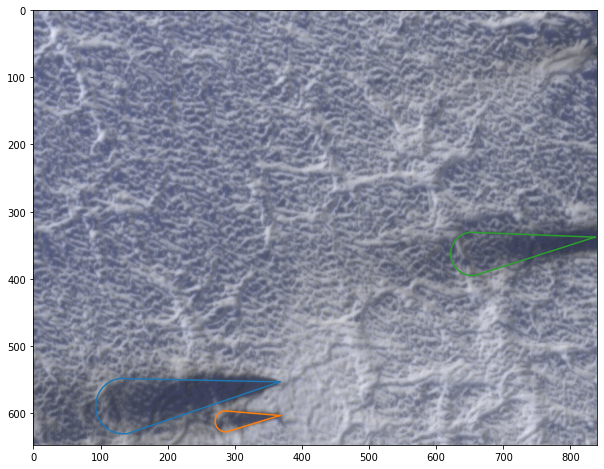

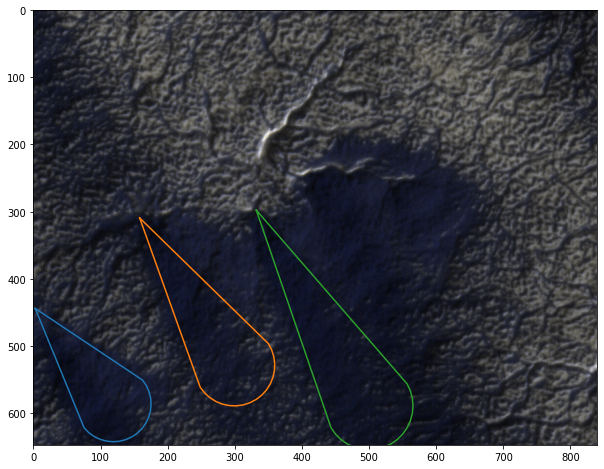

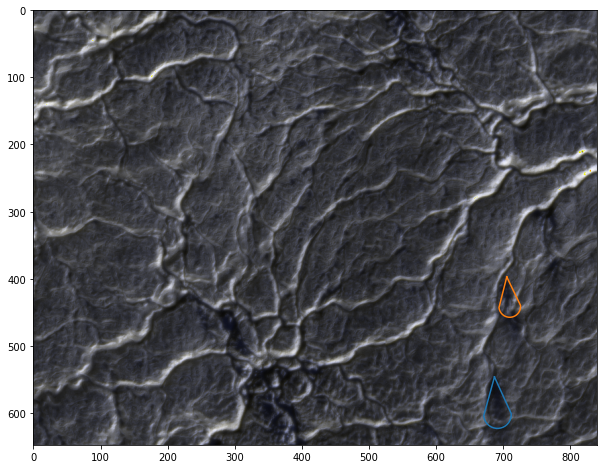

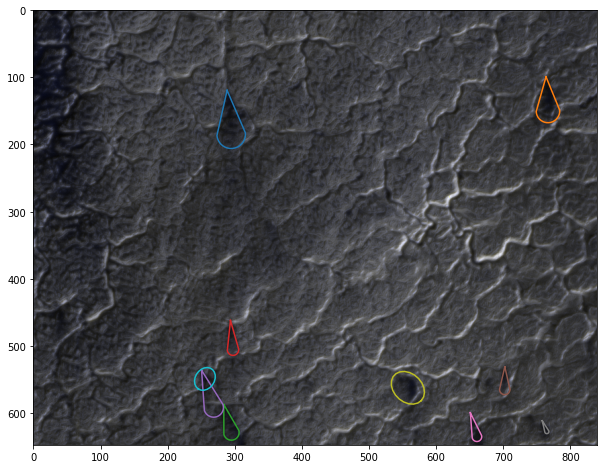

In [42]:
from tqdm import tqdm
import os
import glymur
import cv2
import requests
import json
import hashlib
import random

def download_file(filename):
    savename = data_location + "/{filename}_RGB.NOMAP.JP2".format(filename=filename)
    if os.path.exists(savename):
        print("{} exists".format(savename))
        return
    components = filename.split("_")
    l = 100*int(int(components[1])/100)
    h = 100*int(1+int(components[1])/100)-1
    url="https://hirise-pds.lpl.arizona.edu/download/PDS/EXTRAS/RDR/ESP/ORB_{low:06d}_{high:06d}/{filename}/{filename}_RGB.NOMAP.JP2".format(low=l,high=h,filename=filename)
    print(url)
    myfile = requests.get(url)
    with open(savename, 'wb') as file:
      file.write(myfile.content)
      file.flush()
      file.close()
    
def load_file(filename):
    savename = data_location + "/{filename}_RGB.NOMAP.JP2".format(filename=filename)
    if not os.path.exists(savename):
        download_file(filename)
    return glymur.Jp2k(savename)


nx,ny = 840, 648

def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

def fan_mask(fan, tile):
    xc,yc = fan.image_x - (tile.x_hirise-nx//2),fan.image_y - (tile.y_hirise-ny//2)
    
    fan_s = fan.distance / (1+np.tan(np.deg2rad(fan.spread//2)))
    fan_r = fan_s * np.tan(np.deg2rad(fan.spread//2))
    circ_c_points = np.cos(np.deg2rad(np.arange(0,180,10)))
    circ_s_points = np.sin(np.deg2rad(np.arange(0,180,10)))
    xp = np.hstack([0,
          fan_s,
          fan_s+fan_r*circ_s_points,
          fan_s,
          0
         ])
    yp = np.hstack([0,
          fan_r,
          fan_r*circ_c_points,
          -fan_r,
          0
         ])
    rx,ry = np.cos(np.deg2rad(fan.angle)), np.sin(np.deg2rad(fan.angle))
    rot = np.array([[rx,-ry],[ry,rx]])
    xr,yr=np.dot(rot,np.vstack([xp,yp]))

    return (xc+xr, yc+yr)

def blotch_mask(blotch, tile):
    xc,yc = blotch.image_x - (tile.x_hirise-nx//2),blotch.image_y - (tile.y_hirise-ny//2)

    t = np.linspace(0, 2*np.pi, 22)
    xp = blotch.radius_1 * np.cos(t)
    yp = blotch.radius_2 * np.sin(t)

    rx,ry = np.cos(np.deg2rad(blotch.angle)), np.sin(np.deg2rad(blotch.angle))
    rot = np.array([[rx,-ry],[ry,rx]])
    xr,yr=np.dot(rot,np.vstack([xp,yp]))

    return (xc+xr, yc+yr)


def get_image(tiles_coord, jp, irow):
    row = tiles_coord.iloc[irow]
    sx = slice(int(row.x_hirise-nx//2),int(row.x_hirise+nx//2))
    sy = slice(int(row.y_hirise-ny//2),int(row.y_hirise+ny//2))
    im16 = np.copy(jp[sy,sx])
    ratio = np.amax(im16) / 256
    img8 = (im16 / ratio).astype('uint8')
    return img8

def show_image(tiles_coord, fan_or_blotch, jp, irow, isfan=True):
    """
    isfan: True for fan and False for blotch
    """
    row = tiles_coord.loc[irow]
    img8 = get_image(tiles_coord, jp, irow)
    cv2_imshow(img8)

    if isfan:
      myfans = fan_or_blotch[fan_or_blotch.tile_id == tiles_coord.loc[irow].tile_id]
      for ifan, fan in myfans.iterrows():
          x,y = fan_mask(fan, row)
          plt.plot(x,y,alpha=1.0)
    else:
      myblotches = fan_or_blotch[fan_or_blotch.tile_id == tiles_coord.loc[irow].tile_id]
      print(tiles_coord.loc[irow].tile_id)
      for iblotch, blotch in myblotches.iterrows():
          x,y = blotch_mask(blotch, row)
          plt.plot(x,y,alpha=1.0)

    return None #img8 This will return an array as well

for irow in [1,100,899,1000]:
    row = tiles_coord.iloc[irow]
    jp = load_file(row.obsid)
    plt.figure(figsize = (16,8))
    show_image(tiles_coord, fan, jp, irow)
    show_image(tiles_coord, blotch, jp, irow, False)

In [ ]:
# I'd like to optimise the ratio of overlap between boxes and fan masks. 